In [1]:
# Source: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download

# Preliminary Steps

In [2]:
# Importing librarires
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Sklearn
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# Loading data
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
display(df.head())
df.info()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


### Cleaning

In [4]:
df = df.drop(columns = 'id') # this feature is useless and not predictive
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [5]:
print('There are',df.duplicated().sum(),'duplicate rows.')

There are 0 duplicate rows.


In [6]:
# Locating missing values

In [7]:
df.count()

gender               5110
age                  5110
hypertension         5110
heart_disease        5110
ever_married         5110
work_type            5110
Residence_type       5110
avg_glucose_level    5110
bmi                  4909
smoking_status       5110
stroke               5110
dtype: int64

In [8]:
print('There are', df.isna().sum().sum(),'missing values:')
print(df.isna().sum())
print((df.isna().sum().sum()/5110)*100)

There are 201 missing values:
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64
3.9334637964774952


Since our missing values consitute less than 5 percent of the data, we will go ahead and drop those rows

In [9]:
df.dropna(inplace = True)
print('There are', df.isna().sum().sum(),'missing values:')

There are 0 missing values:


In [10]:
# Looking for inconsistencies in categorical values
for col in df.columns:
    if df[col].dtype == 'object':
        print(col,':\n',df[col].unique(),'\n')

gender :
 ['Male' 'Female' 'Other'] 

ever_married :
 ['Yes' 'No'] 

work_type :
 ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked'] 

Residence_type :
 ['Urban' 'Rural'] 

smoking_status :
 ['formerly smoked' 'never smoked' 'smokes' 'Unknown'] 



Nothing out of the ordinary here.

In [11]:
# Looking for outliers in numerical data
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000
mean,42.865374,0.091872,0.049501,105.305150,28.893237,0.042575
std,22.555115,0.288875,0.216934,44.424341,7.854067,0.201917
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.070000,23.500000,0.000000
50%,44.000000,0.000000,0.000000,91.680000,28.100000,0.000000
75%,60.000000,0.000000,0.000000,113.570000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


An age of .08 isn't possible. And a bmi of 10.3 is unrealistic/fatal. I'll remove these values from the data. 

In [12]:
df = df[df['age'] > 1] # any lower of an age is impossible
df = df[df['bmi'] >15] # any lower of a bmi is unrealistic/severely underweight and very questionable
# rechecking for outliers
df.describe()	

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4825.000000,4825.000000,4825.000000,4825.000000,4825.000000,4825.000000
mean,43.502218,0.093264,0.050363,105.400852,29.111358,0.043316
std,22.134258,0.290833,0.218715,44.589156,7.730216,0.203589
min,1.080000,0.000000,0.000000,55.120000,15.100000,0.000000
25%,26.000000,0.000000,0.000000,77.010000,23.800000,0.000000
50%,45.000000,0.000000,0.000000,91.680000,28.200000,0.000000
75%,61.000000,0.000000,0.000000,113.630000,33.200000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


## Univariate Visualizations

<AxesSubplot: xlabel='stroke', ylabel='count'>

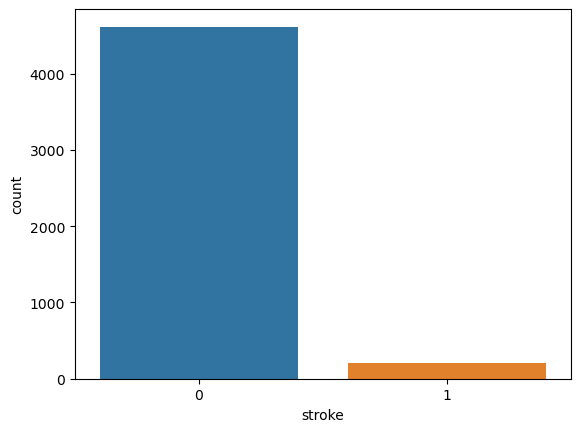

In [13]:
sns.countplot(data = df, x = 'stroke')

<AxesSubplot: xlabel='bmi'>

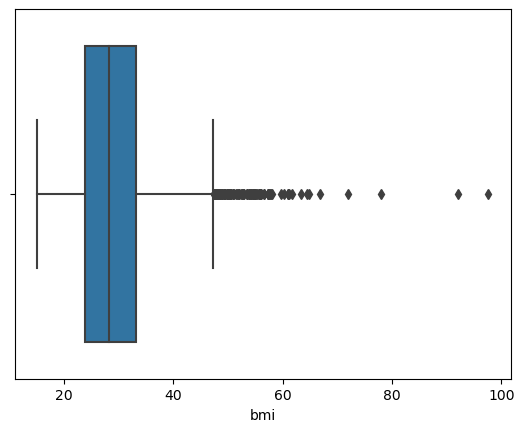

In [14]:
sns.boxplot(df, x ='bmi')

<AxesSubplot: xlabel='count', ylabel='ever_married'>

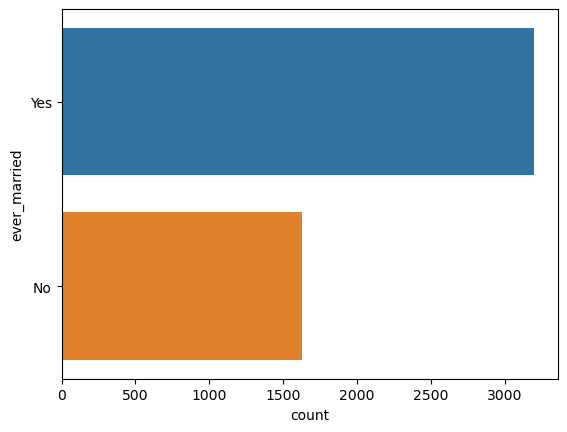

In [15]:
sns.countplot(data=df, y = 'ever_married')

<AxesSubplot: xlabel='age', ylabel='stroke'>

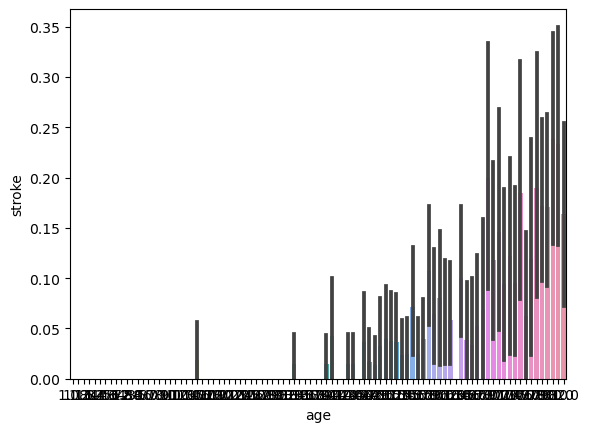

In [16]:
sns.barplot(data=df, x = 'age', y = 'stroke')

<AxesSubplot: xlabel='stroke', ylabel='hypertension'>

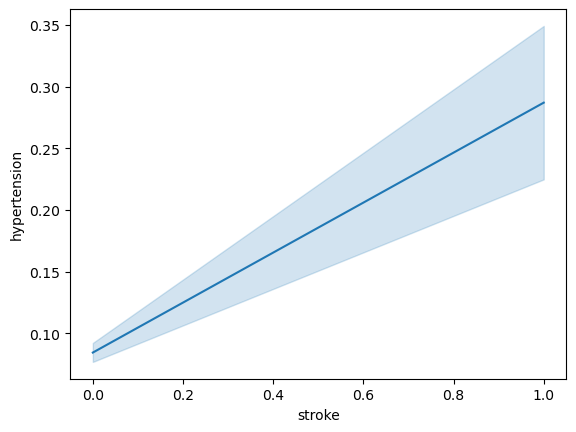

In [17]:
sns.lineplot(data=df, y = 'hypertension', x = 'stroke')

<AxesSubplot: ylabel='avg_glucose_level'>

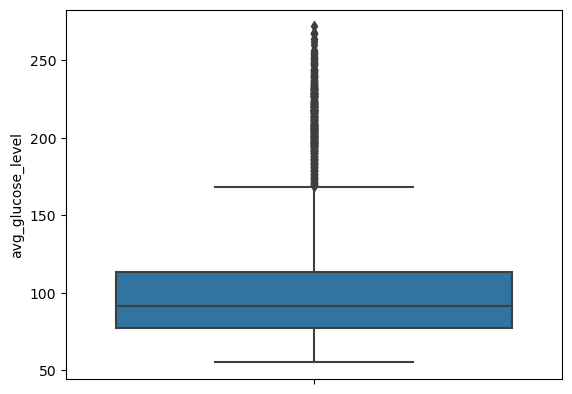

In [18]:
sns.boxplot(data=df, y = 'avg_glucose_level')

<AxesSubplot: xlabel='stroke', ylabel='smoking_status'>

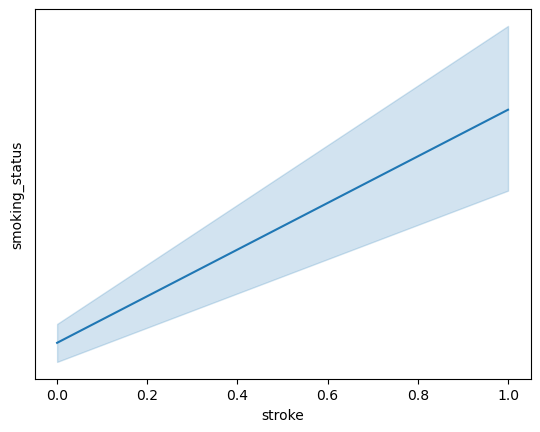

In [19]:
sns.lineplot(data=df, y = 'smoking_status', x = 'stroke')

<AxesSubplot: xlabel='work_type', ylabel='count'>

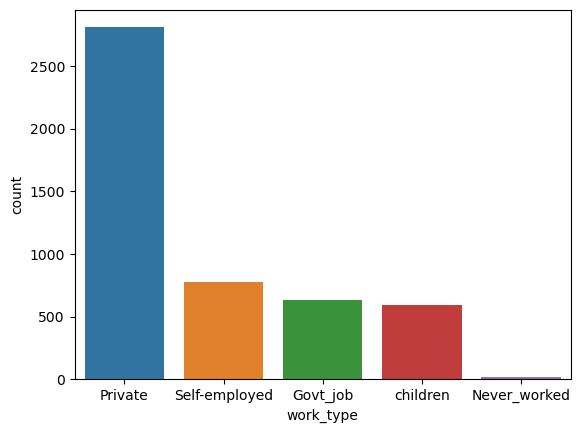

In [20]:
sns.countplot(data = df, x = 'work_type')

<AxesSubplot: xlabel='Residence_type', ylabel='stroke'>

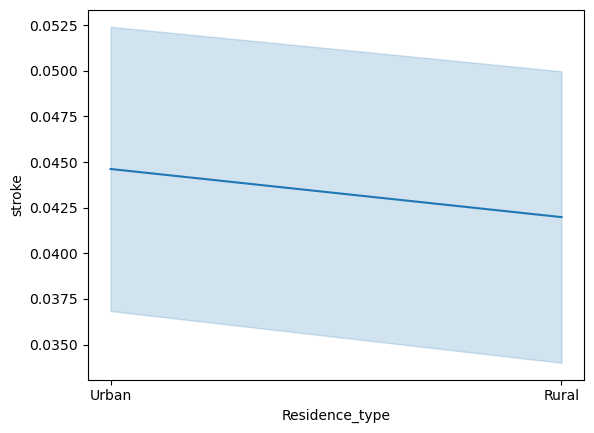

In [21]:
sns.lineplot(data = df, x = 'Residence_type', y = 'stroke')

<AxesSubplot: xlabel='age'>

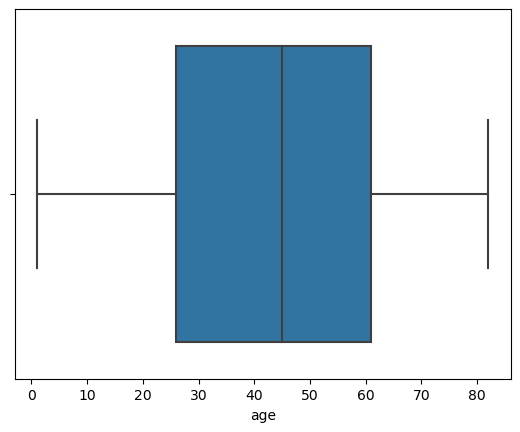

In [22]:
sns.boxplot(data = df, x = 'age')

<AxesSubplot: xlabel='smoking_status', ylabel='count'>

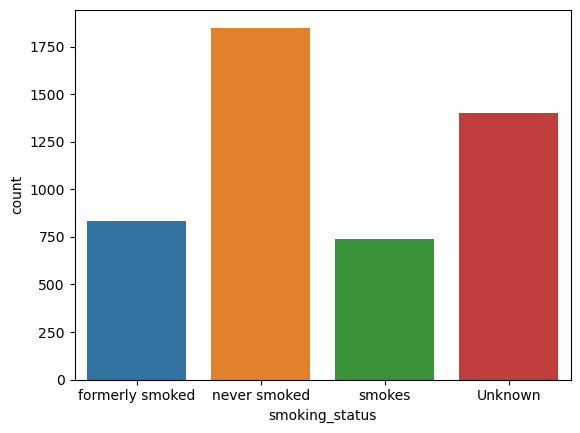

In [23]:
sns.countplot(data = df,x = 'smoking_status')

<AxesSubplot: xlabel='bmi', ylabel='count'>

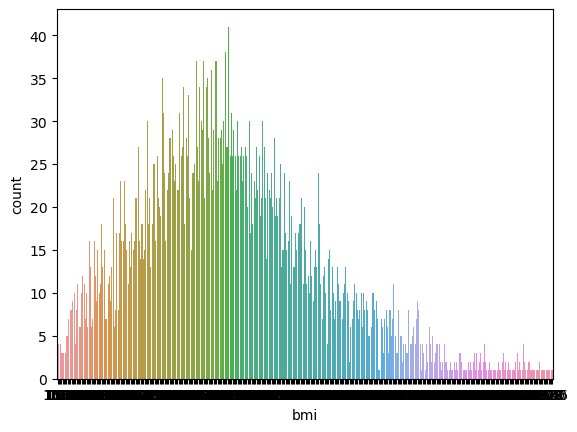

In [24]:
sns.countplot(data = df, x = 'bmi')

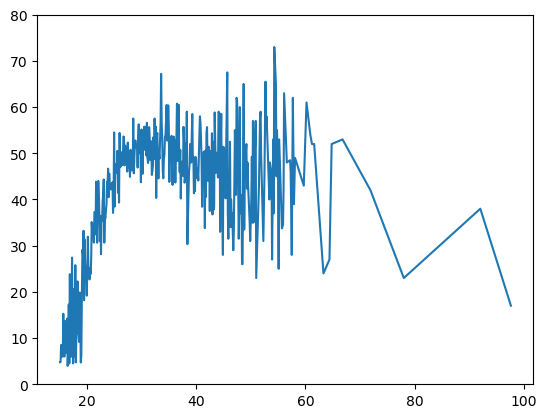

In [25]:
bmi_avg_age=df.groupby(['bmi'])[['age']].mean()
plt.plot(bmi_avg_age)
plt.yticks(range(0,int(df['age'].max()),10));


## Multivariate Visualizations

/var/folders/w6/t6jhm8jd0pnbj_5hvcl1nlsw0000gn/T/ipykernel_54898/1156007998.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),cmap='Purples',annot=True);


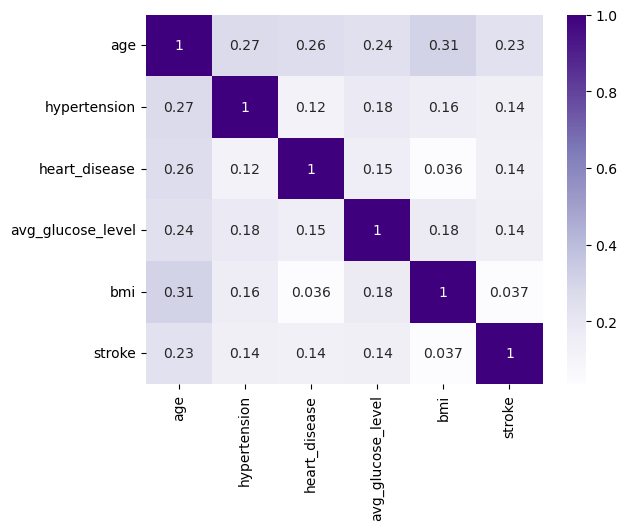

In [26]:
sns.heatmap(df.corr(),cmap='Purples',annot=True);

There is a very low correlation between features and between features and target across the board. None of our features have a correlation of greater than 0.31. The feature with the highest correlation to our 'stroke' target is 'age' with a correlation of 0.23. 

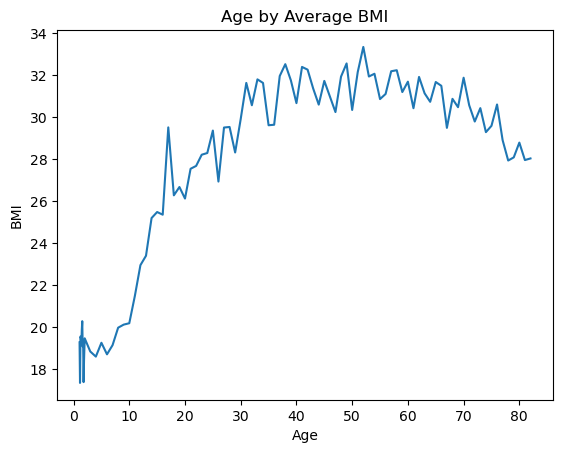

In [27]:
group_age_avg_bmi=df.groupby('age')['bmi'].mean()
plt.plot(group_age_avg_bmi)
plt.ylabel('BMI')
plt.xlabel('Age')
plt.title('Age by Average BMI')
plt.show();

**Trend**:

This plot shows a positive correlation between age and average bmi. The data shows that average bmi increase as age does. Of all features, 'age' has the strongest correlation with our target, 'stroke'. In a way, this correlation demonstrates that having a higher BMI increases the risk of having a stroke.

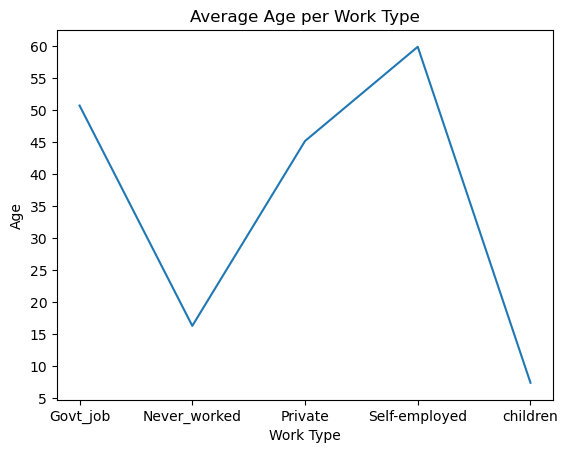

In [28]:
group_work_type_avg_age=df.groupby('work_type')['age'].mean()
plt.plot(group_work_type_avg_age)
plt.title('Average Age per Work Type')
plt.xlabel('Work Type')
plt.ylabel('Age')
plt.yticks(range(5,65,5))
plt.show();

**Trend**:

This plot shows that patients with presumably higher stressful occupations are also older on average. This means that there is an indirect link from 'work_type' and our 'stroke' target. The previously shown heatmap shows the highest correlation between age and risk of stroke. 

# Preprocessing

In [29]:
## Model Validation
# Defining target and features
y=df['stroke']
X=df.drop(columns='stroke')
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
X_train.shape

(3618, 10)

In [30]:
# Column selectors
num_selector = make_column_selector(dtype_include = 'number')
cat_selector = make_column_selector(dtype_include = 'object')
# Individual transformers
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')
# Tuples
num_tuple = (scaler, num_selector)
cat_tuple = (ohe, cat_selector)
# Column Transformer
col_transformer = make_column_transformer(num_tuple, cat_tuple, remainder = 'passthrough')
X_train=col_transformer.fit_transform(X_train)
X_test=col_transformer.transform(X_test)

Data is fully preprocessed and ready for modeling.

# Modeling

## Random Forest

In [31]:
# Instantiating default classification models
rf=RandomForestClassifier(random_state=42)
xgb=XGBClassifier()
# Fitting 
rf.fit(X_train,y_train)
xgb.fit(X_train,y_train)
## Getting predictions
# RandomForest
rf_train_preds=rf.predict(X_train)
rf_test_preds=rf.predict(X_test)
# XGBoost 
xgb_train_preds=xgb.predict(X_train)
xgb_test_preds=xgb.predict(X_test)

[23:53:03] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [32]:
# RandomForest Scores
print('Train Scores:',classification_report(y_train,rf_train_preds))
print('\nTest Scores:',classification_report(y_test,rf_test_preds))

Train Scores:               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3472
           1       1.00      1.00      1.00       146

    accuracy                           1.00      3618
   macro avg       1.00      1.00      1.00      3618
weighted avg       1.00      1.00      1.00      3618


Test Scores:               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1144
           1       0.50      0.02      0.03        63

    accuracy                           0.95      1207
   macro avg       0.72      0.51      0.50      1207
weighted avg       0.93      0.95      0.92      1207



Our default randomforest classfifier scores are terrible. Precision and recall really need an improvement.

## XGBoost 

In [33]:
# XGBoost Scores
print('Train Scores:',classification_report(y_train,xgb_train_preds))
print('\nTest Scores:',classification_report(y_test,xgb_test_preds))

Train Scores:               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3472
           1       1.00      0.97      0.99       146

    accuracy                           1.00      3618
   macro avg       1.00      0.99      0.99      3618
weighted avg       1.00      1.00      1.00      3618


Test Scores:               precision    recall  f1-score   support

           0       0.95      0.99      0.97      1144
           1       0.13      0.03      0.05        63

    accuracy                           0.94      1207
   macro avg       0.54      0.51      0.51      1207
weighted avg       0.91      0.94      0.92      1207



Our XGBoost test scores are terrible. This model is extremely overfit just like our random forest model. Time to tune hyperparameters for both models.

# Tuning using GridSearchCV

## Random Forest

In [34]:
rf.get_params() #finding hyperparameters to tune

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [35]:
## Determining default rf hyperparameters to get an idea of a range of values to loop through with gridsearch
# Getting n_estimators
print(rf.n_estimators)
# getting max est_depths
est_depths = [estimator.get_depth() for estimator in rf.estimators_]
max(est_depths)

100


21

In [36]:
# creating a parameter grid:
rf_params={'max_features': ['sqrt'], # 'sqrt' is good for classification
           'max_depth': [2,4,8,10,15,21], # reasonable set of numbers encompassing our max(est_depths)
           'n_estimators': range(90,105), # range of numbers encompassing default n_estimators
           'class_weight':['balanced']} # making sure our classes are balanced
# Making new gridsearch pipeline
rf_pipe_gs=GridSearchCV(rf,rf_params)
rf_pipe_gs.fit(X_train,y_train) # fitting
print('Best Random Forest Parameters:')
print(rf_pipe_gs.best_params_) # grabbing best parameters
rf_gs_best = rf_pipe_gs.best_estimator_

print(f'Accuracy of best RF model is: {rf_gs_best.score(X_test, y_test)}')

Best Random Forest Parameters:
{'class_weight': 'balanced', 'max_depth': 21, 'max_features': 'sqrt', 'n_estimators': 93}
Accuracy of best RF model is: 0.947804473902237


In [37]:
# creating a new parameter grid to tune more hyperparameters:
rf_params={'max_features': ['sqrt'], # keeping as 'sqrt' performs better with classification problems
           'max_depth': [2,4,8,10,15,21,30,45], # adding depth
           'n_estimators': [50,100,300,500], # heavily increasing n_estimators
           'min_samples_split':[2,5], # adding new hyperparameter
           'min_samples_leaf':[1,2], # adding new hyperparameter
           'bootstrap':[True,False], # adding new hyperparameter 
           'class_weight':['balanced']}
# Making an rf gridsearch pipeline
rf_pipe_gs=GridSearchCV(rf,rf_params)
rf_pipe_gs.fit(X_train,y_train) # fitting
print('Best Random Forest Parameters:')
print(rf_pipe_gs.best_params_) # grabbing best parameters
rf_gs_best = rf_pipe_gs.best_estimator_

print(f'Accuracy of best RF model is: {rf_gs_best.score(X_test, y_test)}')

Best Random Forest Parameters:
{'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 21, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Accuracy of best RF model is: 0.947804473902237


Our hyperparameter tuning has shown zero improvement in accuracy scores. Meaning our recall and precision hasn't gotten any better either. We will choose the quicker model of the two before moving onto XGBoost tuning.

### Scores

In [38]:
# Instantiating tuned RF model
rf_tuned=RandomForestClassifier(class_weight='balanced', max_depth=21, max_features='sqrt', n_estimators= 93) 
rf_tuned.fit(X_train, y_train) #fitting 
# Obtaining new predictions
tuned_rf_train_preds=rf_tuned.predict(X_train)
tuned_rf_test_preds=rf_tuned.predict(X_test)
# Getting scores
# RF Scores
print('Train Scores:',classification_report(y_train, tuned_rf_train_preds))
print('\nTest Scores:',classification_report(y_test, tuned_rf_test_preds))

Train Scores:               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3472
           1       1.00      1.00      1.00       146

    accuracy                           1.00      3618
   macro avg       1.00      1.00      1.00      3618
weighted avg       1.00      1.00      1.00      3618


Test Scores:               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1144
           1       0.50      0.02      0.03        63

    accuracy                           0.95      1207
   macro avg       0.72      0.51      0.50      1207
weighted avg       0.93      0.95      0.92      1207



In [39]:
# Instantiating tuned RF model
rf_tuned=RandomForestClassifier(max_features='sqrt',max_depth=3,n_estimators=90,)
rf_tuned.fit(X_train, y_train) # fitting 
# Obtaining new predictions
tuned_rf_train_preds=rf_tuned.predict(X_train)
tuned_rf_test_preds=rf_tuned.predict(X_test)
# Getting scores
# RF Scores
print('Train Scores:',classification_report(y_train, tuned_rf_train_preds))
print('\nTest Scores:',classification_report(y_test, tuned_rf_test_preds))

Train Scores:               precision    recall  f1-score   support

           0       0.96      1.00      0.98      3472
           1       0.00      0.00      0.00       146

    accuracy                           0.96      3618
   macro avg       0.48      0.50      0.49      3618
weighted avg       0.92      0.96      0.94      3618


Test Scores:               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1144
           1       0.00      0.00      0.00        63

    accuracy                           0.95      1207
   macro avg       0.47      0.50      0.49      1207
weighted avg       0.90      0.95      0.92      1207



/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Since more tuning decreased all metric scores in both the train and test scores.

## XGBoost

In [40]:
# making a parameter grid to tune solver, penalty, and regularization strength:
xgb_params = {'booster':['gbtree','gblinear','dart'],
              'eta':[.01,.1,1],
              'max_depth':range(3,11),
              'verbosity':[0]}
# Making XGB gridsearch pipeline
xgb_pipe_gs=GridSearchCV(xgb,xgb_params)
xgb_pipe_gs.fit(X_train, y_train) # fitting
print('Best XGB Parameters:')
print(xgb_pipe_gs.best_params_) # grabbing best parameters
xgb_gs_best = xgb_pipe_gs.best_estimator_
print(f'Accuracy of best XGB model is: {xgb_gs_best.score(X_test, y_test)}')


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/Cask

Best XGB Parameters:
{'booster': 'gblinear', 'eta': 0.01, 'max_depth': 3, 'verbosity': 0}
Accuracy of best XGB model is: 0.947804473902237


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [41]:
# making a parameter grid to tune solver, penalty, and regularization strength:
xgb_params = {'booster':['gbtree'],
              'eta':[.01,.1,1],
              'max_depth':range(3,11),
              'verbosity':[0],
              'min_child_weight':[0,1,3,5,10,15]}
# Making XGB gridsearch pipeline
xgb_pipe_gs=GridSearchCV(xgb,xgb_params)
xgb_pipe_gs.fit(X_train, y_train) # fitting
print('Best XGB Parameters:')
print(xgb_pipe_gs.best_params_) # grabbing best parameters
xgb_gs_best = xgb_pipe_gs.best_estimator_
print(f'Accuracy of best XGB model is: {xgb_gs_best.score(X_test, y_test)}')


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/Cask

Best XGB Parameters:
{'booster': 'gbtree', 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 15, 'verbosity': 0}
Accuracy of best XGB model is: 0.9469759734879868


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Our tuned RandomForest Classifier has outperformed our XGBClassifier. We couldn't get any stronger scores even after tuning the min_child_weight parameter to reduce overfitting. Time to try using PCA to see how it impacts results. But first we'll instantiate the best (quickest) version of our XGB model.

### Scores

In [42]:
## Tuned (Fastest Learned) XGB Model
# Instantiating tuned XGB model
xgb_tuned=XGBClassifier(booster='gblinear', eta= 0.01, max_depth= 3, verbosity= 0)
xgb_tuned.fit(X_train, y_train) #fitting 
# Obtaining new predictions
tuned_xgb_train_preds=xgb_tuned.predict(X_train)
tuned_xgb_test_preds=xgb_tuned.predict(X_test)
# Getting scores for tuned model
print('Train Scores:',classification_report(y_train, tuned_xgb_train_preds))
print('\nTest Scores:',classification_report(y_test, tuned_xgb_test_preds))

Train Scores:               precision    recall  f1-score   support

           0       0.96      1.00      0.98      3472
           1       0.00      0.00      0.00       146

    accuracy                           0.96      3618
   macro avg       0.48      0.50      0.49      3618
weighted avg       0.92      0.96      0.94      3618


Test Scores:               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1144
           1       0.00      0.00      0.00        63

    accuracy                           0.95      1207
   macro avg       0.47      0.50      0.49      1207
weighted avg       0.90      0.95      0.92      1207



/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision an

Since both of our models performed poorly after hyperparameter tuning, we will move on to using PCA to try to obtain higher precision and recall scores.

# PCA

In [43]:
# Re-preparing data for PCA
X_processed=col_transformer.fit_transform(X)
# Instantiating and fitting PCA onto our data
pca=PCA(n_components=.95)
pca.fit(X_train)

PCA(n_components=0.95)

Text(0, 0.5, 'Proportion of Explained Variance')

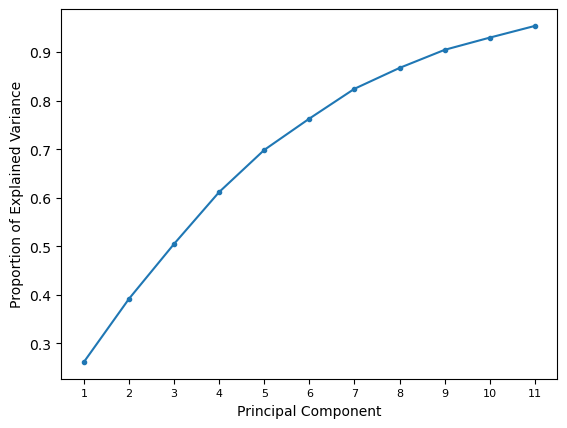

In [44]:
# Visualizing each principal component using Scree Plot:
# Plotting explained variance ratios of the first 11 principal components
plt.plot(range(1, 12), pca.explained_variance_ratio_.cumsum(), marker = '.')
plt.xticks(ticks = range(1, 12), fontsize=8)
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Explained Variance')


Our scree plot shows us that we will end up sacrificing a significant amount of variance per component we decide to extract. This looks likely to cause our already low test scores to drop even lower.

## RandomForeset

I don't want to lose any more than 85% variance so I'll keep my n_components at 9.


In [45]:
# Modeling with tuned RandomForest model and tuned n_components in PCA 
pca_transformer=make_pipeline(ohe,scaler,PCA(n_components=9))
# new Randomforest-PCA pipeline
rf_pca_pipe=make_pipeline(pca_transformer,rf_tuned)
rf_pca_pipe.fit(X_train,y_train)
# Evaluating model
print('Train Scores:',classification_report(y_train, rf_pca_pipe.predict(X_train)))
print('\nTest Scores:',classification_report(y_test, rf_pca_pipe.predict(X_test)))

Train Scores:               precision    recall  f1-score   support

           0       0.96      1.00      0.98      3472
           1       0.00      0.00      0.00       146

    accuracy                           0.96      3618
   macro avg       0.48      0.50      0.49      3618
weighted avg       0.92      0.96      0.94      3618


Test Scores:               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1144
           1       0.00      0.00      0.00        63

    accuracy                           0.95      1207
   macro avg       0.47      0.50      0.49      1207
weighted avg       0.90      0.95      0.92      1207



/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

• Our testing scores did in fact drop. Applying PCA to a dataset like this is definitely more counter-productive to getting higher testing scores.

• Considering what applying PCA is doing here, I expect the same result in our XGBoost model, whose scores are already very low.


## XGB

In [46]:
# Modeling with best (fastest) XGB model and PCA 
# new XGB pipeline
xgb_pca_pipe=make_pipeline(pca_transformer,xgb_tuned)
xgb_pca_pipe.fit(X_train,y_train)
# Evaluating model
print('Train Scores:',classification_report(y_train, xgb_pca_pipe.predict(X_train)))
print('\nTest Scores:',classification_report(y_test, xgb_pca_pipe.predict(X_test)))

Train Scores:               precision    recall  f1-score   support

           0       0.96      1.00      0.98      3472
           1       0.00      0.00      0.00       146

    accuracy                           0.96      3618
   macro avg       0.48      0.50      0.49      3618
weighted avg       0.92      0.96      0.94      3618


Test Scores:               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1144
           1       0.00      0.00      0.00        63

    accuracy                           0.95      1207
   macro avg       0.47      0.50      0.49      1207
weighted avg       0.90      0.95      0.92      1207



/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision an

Just as expected, our XGBoost model performed just as poor with PCA applied to it.

# Choosing a Model

The model with the better scores, in the context of our business problem, is going to be the one with the least amount of false negatives without also sacrificing too many false positives. Less false negatives means less patients deemed "likely to have stroke." *If I were to choose a model of the two utilized, I would choose the tuned RandomForestClassifier.* I'd choose this due to the model having the highest scores overall, It's recall is 0.01 less than that of the XGB model but the precision is much higher at 0.50. In other words, the recall in both models is essentially identical so the higher precision is the deal-breaker.

When comparing both our RandomForest model and our XGBoost  model, after tuning multiple hyperparameters  using GridSearchCV, and after performing feature extraction using PCA we see that there is no significant change in metrics, especially in our poorest performing metrics (precision and recall). In fact, our recall scores in our test set actually decreased in both models after hyperperamater tuning. After applying PCA with 9 components, metrics decreased even further.

One major takeaway from the data is that there simply isn't high enough correlation between features and between features and our target to for any model to demonstrate any significant predictive power. This is evident in our correlation heatmap towards the beginning of the notebook. And further shown through our extremely low recall scores(our most important metrics for the data) in literally all of our models with tuning and feature extraction. With low recall scores like these, there would be a dangerously large amount of patients that wouldn't be considered at risk for stroke when they actually are. 